In [16]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import tensorflow as tf
print(tf.__version__)

2.0.0


In [17]:
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
# make the original data
series = np.sin((0.1*np.arange(400))**2)

This is a time series of the form:

$$ x(t) = \sin(\omega t^2) $$

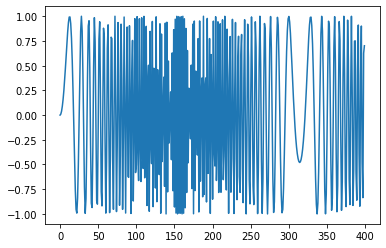

In [19]:
# plot it
plt.plot(series)
plt.show()

In [20]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T) # make it N x T
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10) Y.shape (390,)


In [21]:
### try autoregressive linear model
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 195 samples, validate on 195 samples
Epoch 1/80
195/195 [==============================] - 1s 3ms/sample - loss: 1.5243 - val_loss: 1.5473
Epoch 2/80
195/195 [==============================] - 0s 332us/sample - loss: 1.3121 - val_loss: 1.3611
Epoch 3/80
195/195 [==============================] - 0s 313us/sample - loss: 1.1430 - val_loss: 1.2029
Epoch 4/80
195/195 [==============================] - 0s 311us/sample - loss: 1.0010 - val_loss: 1.0600
Epoch 5/80
195/195 [==============================] - 0s 333us/sample - loss: 0.8837 - val_loss: 0.9618
Epoch 6/80
195/195 [==============================] - 0s 344us/sample - loss: 0.7932 - val_loss: 0.8758
Epoch 7/80
195/195 [==============================] - 0s 337us/sample - loss: 0.7207 - val_loss: 0.8114
Epoch 8/80
195/195 [==============================] - 0s 383us/sample - loss: 0.6605 - val_loss: 0.7580
Epoch 9/80
195/195 [==============================] - 0s 308us/sample - loss: 0.6168 - val_loss: 0.7205
Epoch 10/80
195/195 

195/195 [==============================] - 0s 420us/sample - loss: 0.4894 - val_loss: 0.5622
Epoch 79/80
195/195 [==============================] - 0s 367us/sample - loss: 0.4899 - val_loss: 0.5583
Epoch 80/80
195/195 [==============================] - 0s 359us/sample - loss: 0.4910 - val_loss: 0.5674


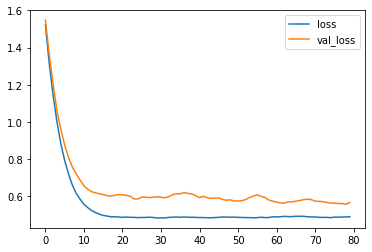

In [22]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(390, 1)


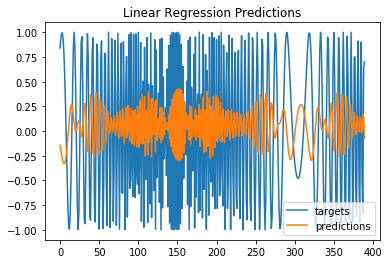

In [23]:
# One-step forecast using true targets
# Note: even the one-step forecast fails badly
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("Linear Regression Predictions")
plt.legend()
plt.show()

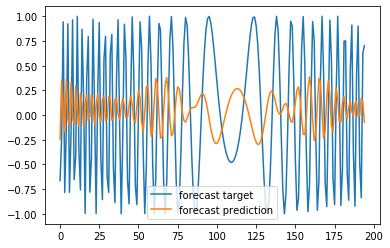

In [24]:
# This is the code we had before - it does the same thing

# One-step forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1, -1))[0,0] # 1x1 array -> scalar
  i += 1
  
  # update the predictions list
  validation_predictions.append(p)

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

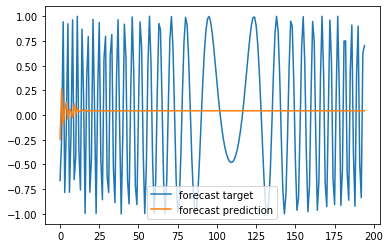

In [25]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [26]:
### Now try RNN/LSTM model
X = X.reshape(-1, T, 1) # make it N x T x D

# make the RNN
i = Input(shape=(T, D))
x = LSTM(10)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.05),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  batch_size=32,
  epochs=200,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 195 samples, validate on 195 samples
Epoch 1/200
195/195 [==============================] - 4s 19ms/sample - loss: 0.5460 - val_loss: 0.5133
Epoch 2/200
195/195 [==============================] - 0s 911us/sample - loss: 0.5004 - val_loss: 0.6448
Epoch 3/200
195/195 [==============================] - 0s 854us/sample - loss: 0.5098 - val_loss: 0.6737
Epoch 4/200
195/195 [==============================] - 0s 853us/sample - loss: 0.4482 - val_loss: 0.4761
Epoch 5/200
195/195 [==============================] - 0s 863us/sample - loss: 0.3845 - val_loss: 0.5119
Epoch 6/200
195/195 [==============================] - 0s 866us/sample - loss: 0.2647 - val_loss: 0.3140
Epoch 7/200
195/195 [==============================] - 0s 853us/sample - loss: 0.2204 - val_loss: 0.3615
Epoch 8/200
195/195 [==============================] - 0s 861us/sample - loss: 0.1651 - val_loss: 0.2161
Epoch 9/200
195/195 [==============================] - 0s 838us/sample - loss: 0.1174 - val_loss: 0.1583
Epoch 10/2

Epoch 78/200
195/195 [==============================] - 0s 862us/sample - loss: 0.0040 - val_loss: 0.0478
Epoch 79/200
195/195 [==============================] - 0s 918us/sample - loss: 0.0036 - val_loss: 0.0517
Epoch 80/200
195/195 [==============================] - 0s 924us/sample - loss: 0.0029 - val_loss: 0.0457
Epoch 81/200
195/195 [==============================] - 0s 941us/sample - loss: 0.0022 - val_loss: 0.0488
Epoch 82/200
195/195 [==============================] - 0s 933us/sample - loss: 0.0018 - val_loss: 0.0488
Epoch 83/200
195/195 [==============================] - 0s 927us/sample - loss: 0.0018 - val_loss: 0.0468
Epoch 84/200
195/195 [==============================] - 0s 926us/sample - loss: 0.0018 - val_loss: 0.0440
Epoch 85/200
195/195 [==============================] - 0s 911us/sample - loss: 0.0021 - val_loss: 0.0494
Epoch 86/200
195/195 [==============================] - 0s 948us/sample - loss: 0.0027 - val_loss: 0.0477
Epoch 87/200
195/195 [========================

195/195 [==============================] - 0s 872us/sample - loss: 0.0023 - val_loss: 0.0465
Epoch 155/200
195/195 [==============================] - 0s 867us/sample - loss: 0.0018 - val_loss: 0.0571
Epoch 156/200
195/195 [==============================] - 0s 880us/sample - loss: 0.0015 - val_loss: 0.0501
Epoch 157/200
195/195 [==============================] - 0s 870us/sample - loss: 0.0013 - val_loss: 0.0536
Epoch 158/200
195/195 [==============================] - 0s 847us/sample - loss: 0.0017 - val_loss: 0.0487
Epoch 159/200
195/195 [==============================] - 0s 862us/sample - loss: 0.0020 - val_loss: 0.0468
Epoch 160/200
195/195 [==============================] - 0s 871us/sample - loss: 0.0019 - val_loss: 0.0598
Epoch 161/200
195/195 [==============================] - 0s 869us/sample - loss: 0.0024 - val_loss: 0.0535
Epoch 162/200
195/195 [==============================] - 0s 893us/sample - loss: 0.0030 - val_loss: 0.0549
Epoch 163/200
195/195 [============================

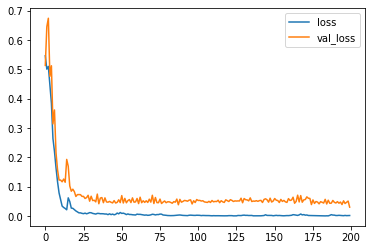

In [27]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

(390, 1)


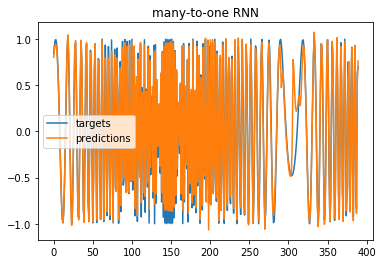

In [28]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("many-to-one RNN")
plt.legend()
plt.show()

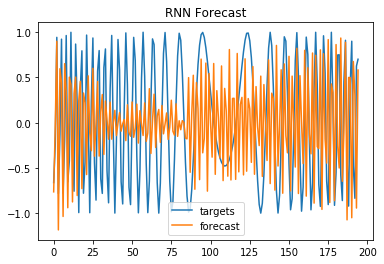

In [29]:
# Multi-step forecast
forecast = []
input_ = X[-N//2]
while len(forecast) < len(Y[-N//2:]):
  # Reshape the input_ to N x T x D
  f = model.predict(input_.reshape(1, T, 1))[0,0]
  forecast.append(f)

  # make a new input with the latest forecast
  input_ = np.roll(input_, -1)
  input_[-1] = f

plt.plot(Y[-N//2:], label='targets')
plt.plot(forecast, label='forecast')
plt.title("RNN Forecast")
plt.legend()
plt.show()